In [1]:
import sys
if '/usr/users/vogg/.conda/envs/fairmot/lib/python3.8/site-packages' not in sys.path:
    sys.path.insert(0, '/usr/users/vogg/.conda/envs/fairmot/lib/python3.8/site-packages')
    sys.path.insert(0, '/usr/users/vogg/FairMOT/src')
    sys.path.insert(0, '/usr/users/vogg/FairMOT/src/lib')
    
#import logging
import os
import re
import motmetrics as mm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#import itertools

import _init_paths
#from lib.opts import opts
from tracking_utils.utils import mkdir_if_missing
#from lib.tracking_utils.log import logger
import datasets.jde as datasets
from track import eval_seq

In [43]:
def read_gt_results(filename):

    results_dict = dict()
    files = os.listdir(filename)
    files = [file for file in files if not file.startswith(".")]
    files.sort()

    for i, file in enumerate(files):
        with open(filename + file, 'r') as f:
            for line in f.readlines():
                linelist = line.split(" ")
                fid = i+1

                results_dict.setdefault(fid, list())
                
                #convert center, width, height to tlwh
                linelist[2] = (float(linelist[2]) - float(linelist[4])/2) * 1920
                linelist[3] = (float(linelist[3]) - float(linelist[5])/2) * 1080
                linelist[4] = float(linelist[4]) * 1920
                linelist[5] = float(linelist[5]) * 1080
                
                score = float(1)
                tlwh = tuple(map(float, linelist[2:6]))
                target_id = int(linelist[1])
                results_dict[fid].append((tlwh, target_id, score))
    return(results_dict)

def read_mot_results(filename):
    results_dict = dict()
    if os.path.isfile(filename):
        with open(filename, 'r') as f:
            for line in f.readlines():
                linelist = line.split(',')
                fid = int(linelist[0])
                if fid < 1:
                    continue
                results_dict.setdefault(fid, list())

                box_size = float(linelist[4]) * float(linelist[5])
                
                score = float(linelist[6])

                tlwh = tuple(map(float, linelist[2:6]))
                target_id = int(linelist[1])

                results_dict[fid].append((tlwh, target_id, score))

    return results_dict



### Define evaluation sequences

In [45]:
seqs = ['VID_20210223_123630_0', 'VID_20210223_123817_0', 'VID_20210223_123854_0', 
        'VID_20210224_115455_0', 'VID_20210224_114038_0', 'VID_20210224_115729_0',
       'VID_20210228_153846_0']

seqs = ['Eval' + str(i) for i in range(8,20)]

#seqs = ['VID_20210301_105722_0', 'VID_20210223_123630_0', 'VID_20210227_133440_0', 'VID_20210228_154053_0', 'VID_20210302_103130_0', 
#        'VID_20210301_151229_0', 'VID_20210228_160721_0', 'VID_20210224_114038_0', 'VID_20210224_115729_0', 'VID_20210223_123817_0',
#        'VID_20210301_145312_0', 'VID_20210228_153846_0', 'VID_20210224_115455_0', 'VID_20210223_123854_0', 'VID_20210228_153942_0',
#        'VID_20210301_143635_0', 'VID_20210302_103307_0', 'VID_20210227_133251_0']


In [50]:
def evaluate_model(model, seqs, path = "new_tracking/", animal = "lemur"):
    
    accs = []
    
    for seq in seqs:
        gt_results = read_gt_results(f"/usr/users/agecker/datasets/{animal}_videos_eval/{seq}/labels_with_ids/")
        mot_results = read_mot_results(f"/usr/users/vogg/FairMOT/videos/{path}{seq}.mp4/{model}/results.txt")
        
        acc = mm.MOTAccumulator(auto_id = True)

        for frame_id in range(len(gt_results)):
            frame_id = frame_id + 1
            gt_objs = gt_results.get(frame_id, [])
            trk_objs = mot_results.get(frame_id, [])
            if gt_objs == [] or trk_objs == []:
                continue
            else:
                gt_tlwhs, gt_ids, _ = zip(*gt_objs)
                trk_tlwhs, trk_ids, _ = zip(*trk_objs)

                iou_distance = mm.distances.iou_matrix(gt_tlwhs, trk_tlwhs, max_iou=0.5)
                acc.update(gt_ids, trk_ids, iou_distance)

        accs.append(acc)

    metrics=('mota', 'num_switches', 'idf1')
    mh = mm.metrics.create()

    summary = mh.compute_many(
                accs,
                metrics=metrics,
                names=seqs,
                generate_overall=True
            )
    
    return(summary)

### Evaluate one model

In [51]:
#With overall
model = 'hrnet32'
evaluate_model(model, seqs, path = "lemur_box/")

/usr/users/vogg/FairMOT/videos/lemur_box/Eval8.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval9.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval10.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval11.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval12.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval13.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval14.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval15.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval16.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval17.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval18.mp4/hrnet32/results.txt
/usr/users/vogg/FairMOT/videos/lemur_box/Eval19.mp4/hrnet32/results.txt


,mota,num_switches,idf1
Eval8,0.703457,4,0.696521
Eval9,0.586222,1,0.560811
Eval10,0.797260,2,0.816140
Eval11,0.764738,2,0.525008
Eval12,0.893827,1,0.546510
Eval13,0.637379,13,0.578879
Eval14,0.887732,3,0.663395
Eval15,0.856790,1,0.536545
Eval16,0.172570,2,0.637694
Eval17,0.758696,3,0.530299


In [12]:
#With overall
#model = 'mcqcpz120_0.02_0.3_0.3_0.5'
model = 'mcqcp_z_1e4_190'
evaluate_model(model, seqs, "new_tracking/")

,mota,num_switches,idf1
VID_20210223_123630_0,0.760475,7,0.796699
VID_20210223_123817_0,0.733120,3,0.853954
VID_20210223_123854_0,0.959079,1,0.917408
VID_20210224_115455_0,0.806838,0,0.906766
VID_20210224_114038_0,0.972504,0,0.986060
VID_20210224_115729_0,0.895393,0,0.950296
VID_20210228_153846_0,1.000000,0,1.000000
OVERALL,0.830060,11,0.895765


In [13]:
#With overall
model = 'mcqcpwild_lr_130'
evaluate_model(model, ['VID_20210223_123630_0'])

,mota,num_switches,idf1
VID_20210223_123630_0,0.826816,11,0.720293
OVERALL,0.826816,11,0.720293


### Compare many models

In [ ]:
#['mcqcp2_' + str(elem) for elem in list(range(60,161,10))] + \
models = ['mcqcp' + str(elem) for elem in [130, 200, 210]] + \
    ['mcqcpz' + str(elem) for elem in [200, 140, 270]] + \
    ['mcqcp2_'+ str(elem) for elem in [240, 200, 190]] + \
    ['mcq'+ str(elem) for elem in [210, 280, 290]] + \
    ['oms' + str(elem) for elem in [2,4,6]] + \
    ['mcqcp32_' + str(elem) for elem in [220, 290, 150]]
models = ['mcqcp_1e4_' + str(elem) for elem in list(range(10, 251, 10))] + \
    ['mcqcp_z_1e4_' + str(elem) for elem in list(range(10, 251, 10))] + \
    ['mcqpose_1e4_' + str(elem) for elem in list(range(10, 501, 10))] +\
    ['mcqcpwild_1e4_' + str(elem) for elem in list(range(10, 251, 10))]
#print(models)

In [17]:
#Compare many models
all_models = []

for model in models:
    summary = evaluate_model(model, seqs).iloc[-1:,:]
    summary.index = [model]
    all_models.append(summary)
    

output = pd.concat(all_models)
output

,mota,num_switches,idf1
mcqcp_1e4_10,0.576258,3,0.730929
mcqcp_1e4_20,0.751113,8,0.853375
mcqcp_1e4_30,0.825478,7,0.892948
mcqcp_1e4_40,0.653181,13,0.804292
mcqcp_1e4_50,0.744500,22,0.841987
...,...,...,...
mcqcpwild_1e4_210,0.848401,19,0.877277
mcqcpwild_1e4_220,0.865959,24,0.882255
mcqcpwild_1e4_230,0.865506,23,0.882260
mcqcpwild_1e4_240,0.841954,17,0.875512


In [19]:
output['epoch'] = output.index.str.split("_").map(lambda x: x[-1]).astype(float)
output['model'] = output.index.str.split("_").map(lambda x: x[0])
output['pretrain'] = output.index.str.split("_").map(lambda x: x[1])
output.loc[output.pretrain == "1e4", "pretrain"] = "human"

#get moving average
output['mota_roll'] = output.groupby(['model','pretrain']).mota.transform(lambda s: s.rolling(5, min_periods=1).mean())
output['idf1_roll'] = output.groupby(['model','pretrain']).idf1.transform(lambda s: s.rolling(5, min_periods=1).mean()) 
output['num_switches_roll'] = output.groupby(['model','pretrain']).num_switches.transform(lambda s: s.rolling(5, min_periods=1).mean()) 

output

,mota,num_switches,idf1,epoch,model,pretrain,mota_roll,idf1_roll,num_switches_roll
mcqcp_1e4_10,0.576258,3,0.730929,10.0,mcqcp,human,0.576258,0.730929,3.00
mcqcp_1e4_20,0.751113,8,0.853375,20.0,mcqcp,human,0.663686,0.792152,5.50
mcqcp_1e4_30,0.825478,7,0.892948,30.0,mcqcp,human,0.717616,0.825750,6.00
mcqcp_1e4_40,0.653181,13,0.804292,40.0,mcqcp,human,0.701508,0.820386,7.75
mcqcp_1e4_50,0.744500,22,0.841987,50.0,mcqcp,human,0.710106,0.824706,10.60
...,...,...,...,...,...,...,...,...,...
mcqcpwild_1e4_210,0.848401,19,0.877277,210.0,mcqcpwild,human,0.838126,0.877603,15.00
mcqcpwild_1e4_220,0.865959,24,0.882255,220.0,mcqcpwild,human,0.846039,0.880867,17.20
mcqcpwild_1e4_230,0.865506,23,0.882260,230.0,mcqcpwild,human,0.857431,0.887365,18.60
mcqcpwild_1e4_240,0.841954,17,0.875512,240.0,mcqcpwild,human,0.855751,0.880206,20.40


<ipython-input-22-4101781d3588>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  subset3['epoch'] /= 2


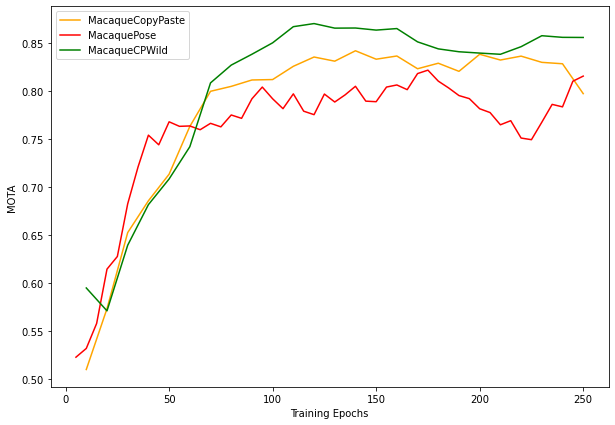

In [22]:
metric = "mota_roll"

#subset1 = output[(output.pretrain == "human") & (output.model == "mcqcp")]
subset2 = output[(output.pretrain == "z") & (output.model == "mcqcp")]
subset3 = output[output.model == "mcqpose"]
subset3['epoch'] /= 2
subset4 = output[output.model == "mcqcpwild"]

fig, ax = plt.subplots(figsize=(10, 7))
#line1,  = ax.plot(subset1.epoch, subset1[metric], c = "blue")
line2,  = ax.plot(subset2.epoch, subset2[metric], c = "orange")
line3,  = ax.plot(subset3.epoch, subset3[metric], c = "red")
line4,  = ax.plot(subset4.epoch, subset4[metric], c = "green")
#ax.plot(output.epoch, 1 - (output.num_switches / (output.num_switches.max() * 2)))
ax.set_xlabel("Training Epochs")
ax.set_ylabel("MOTA")
ax.legend([line2, line3, line4], ['MacaqueCopyPaste', 'MacaquePose', 'MacaqueCPWild'])

## Thresholds

We have four thresholds which can be tuned for a better detection / tracking result. We will tweak them with the currently best model mcq180.pth to see if we can improve performance even further.
- Confidence threshold (conf): what is the minimum heatmap confidence to accept something as a potential detection.
- similarity threshold (sim): When doing the linear matching, what is the minimum required similarity of a track to a new detection, so that they can be matched
- New track threshold (det): how confident does a detection have to be to form a new track in case it is not matched to any existing track
- New overlap threshold (overlap): how much can a detection overlap with an existing track and still form a new track

In [35]:
combs = []

for conf in [0.02]:
    for sim in [0.3]:
        for det in [0.3, 0.4, 0.5, 0.6, 0.7]:
            for overlap in [0.5]:
                combs.append("hrnet32"+str(conf)+"_"+str(sim)+"_"+str(det)+"_"+str(overlap))

In [38]:
all_models = []

for model in combs:
    summary = evaluate_model(model, seqs, path = "lemur_thresholds/").iloc[-1:,:]
    summary.index = [model]
    all_models.append(summary)
    

output = pd.concat(all_models)
output

FileNotFoundError: [Errno 2] No such file or directory: '/usr/users/agecker/datasets/macaque_videos/Eval8/labels_with_ids/'

In [28]:
summary = output
summary['index1'] = summary.index

summary['confidence'] = summary['index1'].str.split("_").map(lambda x: x[1]).astype(float)
summary['embedding_sim'] = summary['index1'].str.split("_").map(lambda x: x[2]).astype(float)
summary['new_det'] = summary['index1'].str.split("_").map(lambda x: x[4]).astype(float)

summary = summary.drop(columns = ['index1'])

IndexError: list index out of range

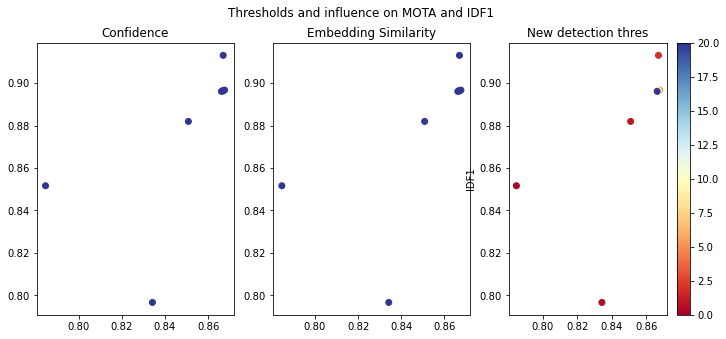

In [119]:
cm = plt.cm.get_cmap('RdYlBu')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12,5))
fig.suptitle('Thresholds and influence on MOTA and IDF1')

ax1.scatter(summary.mota, summary.idf1, 
                 c = summary.confidence, cmap=cm, vmin = 0)
ax1.set_title("Confidence")

ax2.scatter(summary.mota, summary.idf1, 
                 c = summary.embedding_sim, cmap=cm, vmin = 0)
ax2.set_title("Embedding Similarity")

cm = ax3.scatter(summary.mota, summary.idf1, 
                 c = summary.new_det, cmap=cm, vmin = 0)
ax3.set_ylabel("IDF1")
ax3.set_title("New detection thres")

plt.colorbar(cm)